In [1]:
import anndata as ad
import scanpy as sc

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import torch

from propose import PROPOSE, ExpressionDataset

/home/rohan/miniconda3/envs/propose/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load and process dataset**

In [2]:
# see 00_data_proc.ipynb for details on how the .h5ad file was created
adata = ad.read_h5ad('./VISp_dataset/VISp_filtered.h5ad')

# convert categorical cell type labels to numbers
adata.obs['cell_types_25_codes'] = pd.Categorical(adata.obs['cell_types_25']).codes

# save binarized data in a separate layer
adata.layers['bin'] = (adata.X>0).astype(np.float32)

print(adata)

AnnData object with n_obs × n_vars = 13349 × 10000
    obs: 'seq_name', 'class', 'subclass', 'cluster', 'cell_types_98', 'cell_types_50', 'cell_types_25', 'cell_types_25_codes'
    var: 'highly_variable'
    uns: 'hvg', 'log1p'
    layers: 'log1pcpm', 'bin'


**Create training and validation splits**

In [3]:
# Choose training and validation splits. 
# You may want to use a different strategy to choose these - see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
train_ind, val_ind = sk.model_selection.train_test_split(np.arange(adata.shape[0]), train_size=0.8)

print(f'{adata.shape[0]} total samples')
print(f'{np.size(train_ind)} in training set')
print(f'{np.size(val_ind)} in validation set')

# These are views, so they do not take up memory
adata_train = adata[train_ind,:]
adata_val = adata[val_ind,:]

13349 total samples
10679 in training set
2670 in validation set


**Run PROPOSE**
 - Here the task is to select gene sets that can be used for cell type classification.
 - The reference is a scRNA-seq dataset, and the application might be selecting genes for an mFISH experiment where we want to recover cell type identity.
 - We choose input to be the binarized gene expression values to make results robust to domain shift (scRNA-seq vs. mFISH expression)
 - We use PROPOSE with a cross entropy loss function, which is standard practice to train models for a classification problem. 

In [4]:
# Initialize the dataset for PROPOSE
# Note: Here, data_train.layers['bin'] is a sparse array
# data_train.layers['bin'].A converts it to a dense array
train_dataset = ExpressionDataset(adata_train.layers['bin'].A, adata_train.obs['cell_types_25_codes'])
val_dataset = ExpressionDataset(adata_val.layers['bin'].A, adata_val.obs['cell_types_25_codes'])


# Use GPU device if available -- we highly recommend using a GPU!
device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

# Number of genes to select within the current selection process.
num_genes = (32, 64)
propose_results = {}

# Set up the PROPOSE selector
selector = PROPOSE(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   device=device,
                   hidden=[128, 128])

# Coarse removal of genes
print('Starting initial elimination...')
candidates, model = selector.eliminate(target=500, mbsize=128, max_nepochs=250)
print('Completed initial elimination.')

print('Selecting specific number of genes...')
for num in num_genes:
    inds, model = selector.select(num_genes=num, mbsize=128, max_nepochs=250)
    propose_results[num] = inds
print('Done')

Starting initial elimination...
using CrossEntropyLoss, starting with lam = 0.0001


Training epochs: 100%|██████████| 250/250 [06:25<00:00,  1.54s/it]


lam = 0.000100 yielded 162 genes
Reinitializing model for next iteration
next attempt is lam = 0.000031


Training epochs: 100%|██████████| 250/250 [06:28<00:00,  1.56s/it]


lam = 0.000031 yielded 407 genes
done, lam = 0.000031 yielded 407 genes
Completed initial elimination.
Selecting specific number of genes...


Training epochs: 100%|██████████| 250/250 [04:56<00:00,  1.18s/it]


done, selected 32 genes


Training epochs: 100%|██████████| 250/250 [04:54<00:00,  1.18s/it]

done, selected 64 genes
Done


In [5]:
# obtain a copy of features from the anndata object
# Note: Without the .copy(), you will modify adata itself, which may be desirable in some use cases.
df = adata.var.copy()

# set a boolean = True for genes selected in any of the rounds
for num in num_genes:
    df[f'propose_set_{num}'] = False
    ind = df.iloc[propose_results[num]].index
    df.loc[ind,f'propose_set_{num}'] = True

In [6]:
# only keep features (genes) that were selected in any set by propose, and save for subsequent use
df = df[df[[f'propose_set_{num}' for num in num_genes]].any(axis=1)]

df.head(2)

,highly_variable,propose_set_32,propose_set_64
genes,,,
Atp6ap1l,True,False,True
Bmp3,True,True,False


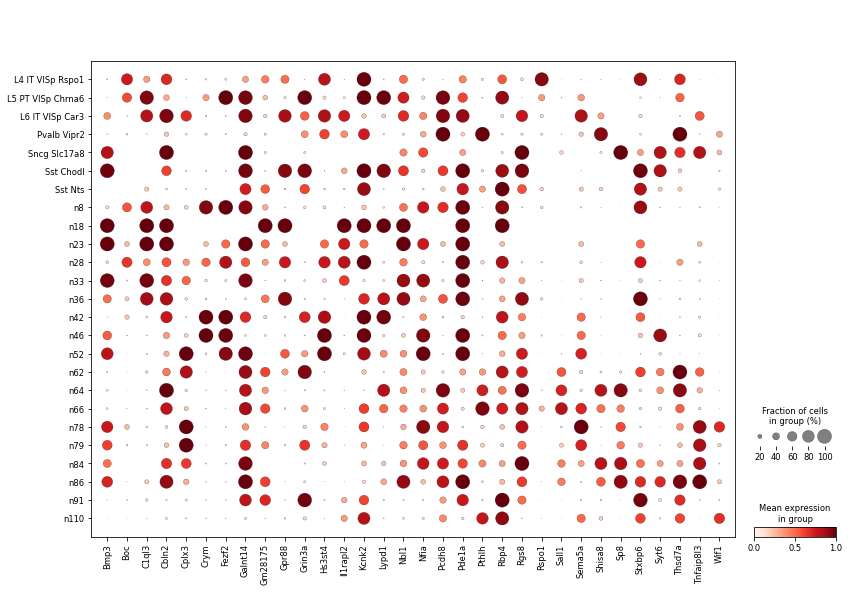

In [7]:
# Plot average binarized expression pattern for selection across cell types:
sc.pl.dotplot(adata,
              var_names=df[df['propose_set_32']].index.values,
              groupby='cell_types_25',
              layer='bin')
plt.show()

**Performance (TBD)**
- The user may be interested in the average expression patterns for the selected genes
- Train an independent classifier to assess cell type classification with the selected genes

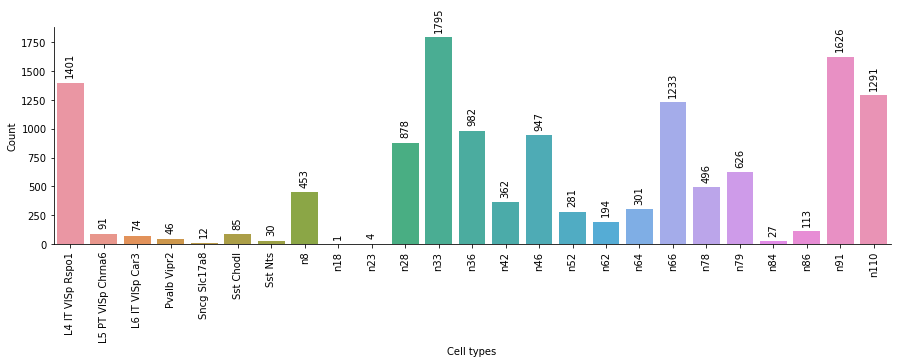

In [8]:
import seaborn as sns

f, ax = plt.subplots(1,1,figsize=(15,4))
sns.countplot(data=adata.obs,
              x='cell_types_25',
              ax=ax,
              linewidth=.5)
bl = ax.bar_label(ax.containers[0], padding=5)
[b.set_rotation(90) for b in bl]
ax.tick_params(axis='x', labelrotation=90)
ax.set(xlabel='Cell types', ylabel='Count')
sns.despine(ax=ax)
plt.show()